# Problem Statement Description:

An online question and answer platform has hired you as a data scientist to identify the best question authors on the platform. This identification will bring more insight into increasing the user engagement. Given the tag of the question, number of views received, number of answers, username and reputation of the question author, the problem requires you to predict the upvote count that the question will receive.

### Data Dictionary

- ***Variable Definition***

    * ID : Question ID

    * Tag : Anonymised tags representing question category

    * Reputation : Reputation score of question author

    * Answers : Number of times question has been answered

    * Username : Anonymised user id of question author

    * Views : Number of times question has been viewed

    * Upvotes (Target) : Number of upvotes for the question

## Code to read csv file into Colaboratory:

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '1khMLab9la1lH5FcHUZHTy-S0BOlXi9W3'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_NIR5Yl1.csv')  

## Importing the necessary libraries 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading data and Data Preprocessing

In [ ]:
#reading the data into a dataframe

df = pd.read_csv("train_NIR5Yl1.csv")
df.head()


,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [ ]:
#getting the info of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330045 entries, 0 to 330044
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          330045 non-null  int64  
 1   Tag         330045 non-null  object 
 2   Reputation  330045 non-null  float64
 3   Answers     330045 non-null  float64
 4   Username    330045 non-null  int64  
 5   Views       330045 non-null  float64
 6   Upvotes     330045 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 17.6+ MB


In [ ]:
#this command shows all the mathematical values of the dataframe

df.describe()

,ID,Reputation,Answers,Username,Views,Upvotes
count,330045.000000,3.300450e+05,330045.000000,330045.000000,3.300450e+05,330045.000000
mean,235748.682789,7.773147e+03,3.917672,81442.888803,2.964507e+04,337.505358
std,136039.418471,2.706141e+04,3.579515,49215.100730,8.095646e+04,3592.441135
min,1.000000,0.000000e+00,0.000000,0.000000,9.000000e+00,0.000000
25%,117909.000000,2.820000e+02,2.000000,39808.000000,2.594000e+03,8.000000
50%,235699.000000,1.236000e+03,3.000000,79010.000000,8.954000e+03,28.000000
75%,353620.000000,5.118000e+03,5.000000,122559.000000,2.687000e+04,107.000000
max,471493.000000,1.042428e+06,76.000000,175738.000000,5.231058e+06,615278.000000


In [ ]:
#checking the values of Views column with 

df = df[df['Views']>df['Upvotes']]
df.shape

(329956, 7)

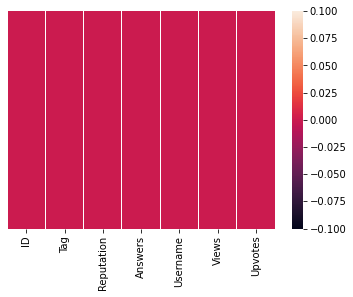

In [ ]:
#this is the visual representation of the number of null values and this 
#plot shows that there are no null values

sns.heatmap(df.isnull(),yticklabels=False)

In [ ]:
#the below code is a function to find the duplicate columns

def finding_duplicates(df):
  duplicated_columns = set()                                  #a set is taken to store the duplicated column names
  for x in range(df.shape[1]):                                #this considers the columns of the dataset
    col1 = df.iloc[:,x]                                       #first column with whom the second column will be compared
    for y in range(x+1,df.shape[1]):                          #the for loop starts just after the first column 
      col2 = df.iloc[:,y]                                     #the second column for comparison with the first one
      if col1.equals(col2):                                   #the code for comparison
          duplicated_columns.add(df.columns.values[y])        #if any duplicated cols are found then they are added to this set
  return list(duplicated_columns)                             #the list of duplicated cols are returned

### Part of feature engineering but done before, new feature created

In [ ]:
#creating a new feature, rep_inc_per_view is the increase in reputation per increase in views

df['rep_inc_per_view'] = df['Reputation']/df['Views']
df.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,rep_inc_per_view
0,52664,a,3942.0,2.0,155623,7855.0,42.0,0.501846
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,0.466766
2,468453,c,1358.0,4.0,56177,8067.0,60.0,0.168340
3,96996,a,264.0,3.0,168793,27064.0,9.0,0.009755
4,131465,c,4271.0,4.0,112223,13986.0,83.0,0.305377


### Part of feature engineering but done before, new feature created

In [ ]:
view_by_tag = pd.Series(df.groupby('Tag')['Views'].sum())

#creating a new feature,views_by_tag is a feature which contains the values of the number of views per tag

df['views_by_tag'] = df.Tag.map(view_by_tag/df.Tag.value_counts())
df.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,rep_inc_per_view,views_by_tag
0,52664,a,3942.0,2.0,155623,7855.0,42.0,0.501846,31812.210845
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,0.466766,31812.210845
2,468453,c,1358.0,4.0,56177,8067.0,60.0,0.168340,26752.019464
3,96996,a,264.0,3.0,168793,27064.0,9.0,0.009755,31812.210845
4,131465,c,4271.0,4.0,112223,13986.0,83.0,0.305377,26752.019464


In [ ]:
#the below result shows that there are no duplicate columns present in this 
#dataframe

finding_duplicates(df)

[]

In [ ]:
#to get the relationship of each column with another and we can see that 
#the correlation of the ID column and the Username column with the 
#Upvotes column is very less and negative respectively
#thus they do not add any valuable information in the building of the model
#so according to my analysis these two columns should be dropped

df.corr()

,ID,Reputation,Answers,Username,Views,Upvotes,rep_inc_per_view,views_by_tag
ID,1.000000,0.008448,0.017435,0.000569,0.017413,0.006280,0.000762,0.020825
Reputation,0.008448,1.000000,0.067624,-0.040781,0.037317,0.267908,0.354978,0.025789
Answers,0.017435,0.067624,1.000000,-0.012227,0.498629,0.202103,-0.040103,0.100182
Username,0.000569,-0.040781,-0.012227,1.000000,0.002292,-0.011884,-0.012337,0.013527
Views,0.017413,0.037317,0.498629,0.002292,1.000000,0.437521,-0.032045,0.118987
Upvotes,0.006280,0.267908,0.202103,-0.011884,0.437521,1.000000,-0.003063,0.039445
rep_inc_per_view,0.000762,0.354978,-0.040103,-0.012337,-0.032045,-0.003063,1.000000,-0.013107
views_by_tag,0.020825,0.025789,0.100182,0.013527,0.118987,0.039445,-0.013107,1.000000


In [ ]:
#dropping the ID column as the values in it are all unique values and if used this column in 
#training the model then it will give importance to the greater values 

df.drop(labels=['ID'],axis=1,inplace=True)
df.head()

,Tag,Reputation,Answers,Username,Views,Upvotes,rep_inc_per_view,views_by_tag
0,a,3942.0,2.0,155623,7855.0,42.0,0.501846,31812.210845
1,a,26046.0,12.0,21781,55801.0,1175.0,0.466766,31812.210845
2,c,1358.0,4.0,56177,8067.0,60.0,0.168340,26752.019464
3,a,264.0,3.0,168793,27064.0,9.0,0.009755,31812.210845
4,c,4271.0,4.0,112223,13986.0,83.0,0.305377,26752.019464


In [ ]:
#Now we can see that the Tag column consists of categorical variables
#so we should encode it as most ml algorithms work with numbers and not 
#categories or labels
#Let's check tyhe number of unique categories and their count values in Tag column

df.Tag.value_counts()

c    72442
j    72210
p    43399
i    32399
a    31682
s    23306
h    20555
o    14546
r    12441
x     6976
Name: Tag, dtype: int64

In [ ]:
#in the above output we can see the count of values of each category 
#c has the highest count and the output below shows that the number of unique 
#categories is equal to 10, if OneHotEcoding is done then 10 more columns will be 
#added to this dataset and thus will increase the complexity of data,
#so OneHotEncoding is not the best solution but Frequency Encoding can be done

df.Tag.nunique()

10

In [ ]:
#in the code snippet below Frequency encoding is applied to the Tag column

df.Tag = df.Tag.map(df.Tag.value_counts().to_dict())
df.head()

,Tag,Reputation,Answers,Username,Views,Upvotes,rep_inc_per_view,views_by_tag
0,31682,3942.0,2.0,155623,7855.0,42.0,0.501846,31812.210845
1,31682,26046.0,12.0,21781,55801.0,1175.0,0.466766,31812.210845
2,72442,1358.0,4.0,56177,8067.0,60.0,0.168340,26752.019464
3,31682,264.0,3.0,168793,27064.0,9.0,0.009755,31812.210845
4,72442,4271.0,4.0,112223,13986.0,83.0,0.305377,26752.019464


In [ ]:
#to see the correlation of each column with other column the below code is used

df.corr()

,Tag,Reputation,Answers,Username,Views,Upvotes,rep_inc_per_view,views_by_tag
Tag,1.000000,0.057022,0.090751,-0.001469,0.069960,0.027513,0.005792,0.587965
Reputation,0.057022,1.000000,0.067624,-0.040781,0.037317,0.267908,0.354978,0.025789
Answers,0.090751,0.067624,1.000000,-0.012227,0.498629,0.202103,-0.040103,0.100182
Username,-0.001469,-0.040781,-0.012227,1.000000,0.002292,-0.011884,-0.012337,0.013527
Views,0.069960,0.037317,0.498629,0.002292,1.000000,0.437521,-0.032045,0.118987
Upvotes,0.027513,0.267908,0.202103,-0.011884,0.437521,1.000000,-0.003063,0.039445
rep_inc_per_view,0.005792,0.354978,-0.040103,-0.012337,-0.032045,-0.003063,1.000000,-0.013107
views_by_tag,0.587965,0.025789,0.100182,0.013527,0.118987,0.039445,-0.013107,1.000000


In [ ]:
#dropping the Username column as the correlation between the Username and the Upvotes(Target) variable 
 
df.drop(labels=['Username'],axis=1,inplace=True)
df.head()

,Tag,Reputation,Answers,Views,Upvotes,rep_inc_per_view,views_by_tag
0,31682,3942.0,2.0,7855.0,42.0,0.501846,31812.210845
1,31682,26046.0,12.0,55801.0,1175.0,0.466766,31812.210845
2,72442,1358.0,4.0,8067.0,60.0,0.168340,26752.019464
3,31682,264.0,3.0,27064.0,9.0,0.009755,31812.210845
4,72442,4271.0,4.0,13986.0,83.0,0.305377,26752.019464


## Data Visualisation and Outlier Detection

In [ ]:
#now the encoding of the cateforical variables are done, I want to see if the
#columns have a normal distribution or not and how each column is related to 
#each other
#the function written below is used to find the distribution of each column of 
#a dataframe using matplotlib hist function

columns_list = ['Tag','Reputation','Answers','Views','rep_inc_per_view','views_by_tag']   #list containing all the column names
def finding_distribution(df):
  fig = plt.figure(figsize=(12,5))                                                        #making the plot figure of a specified size
  fig.subplots_adjust(hspace=1, wspace=1)                                                 #adjusting the space between each plot
  for i in range(1,7):                                                                    #for loop for going through all the column names
    ax = fig.add_subplot(2, 3, i)                                                         #making plots for each column
    ax.hist(df[columns_list[i-1]])                                                        #making the histogram
    ax.set_title(f'Distribution of {columns_list[i-1]}')                                  #setting the title for each distribution

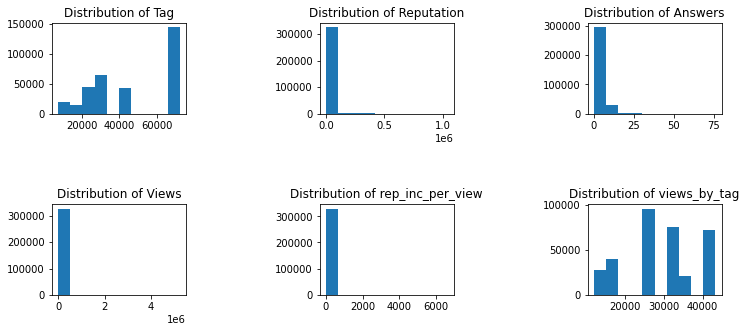

In [ ]:
#calling the function finding_distribution on the dataframe df
#the distribution of Tag column shows that there is an outlier
#the distribution of Reputation,Views,Answers all are right skewed
#as the tail is going extending towards the right side or the positive side

finding_distribution(df)

In [ ]:
#now splitting of the data into train and test sets are done in the code below 
#because all the transformation of the columns to turn it into a normal distribution
#can be done after that so that data loss doesn't happen

X_train,X_test,Y_train,Y_test = train_test_split(df.drop(labels=['Upvotes'],axis=1),df['Upvotes'],test_size = 0.3,random_state=0)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((230969, 6), (98987, 6), (230969,), (98987,))

In [ ]:
#splitting the test set into final test set and validation set

X_validation,X_test_final,Y_validation,Y_test_final = train_test_split(X_test,Y_test,test_size=0.5,random_state = 0)
X_validation.shape,X_test_final.shape,Y_validation.shape,Y_test_final.shape

((49493, 6), (49494, 6), (49493,), (49494,))

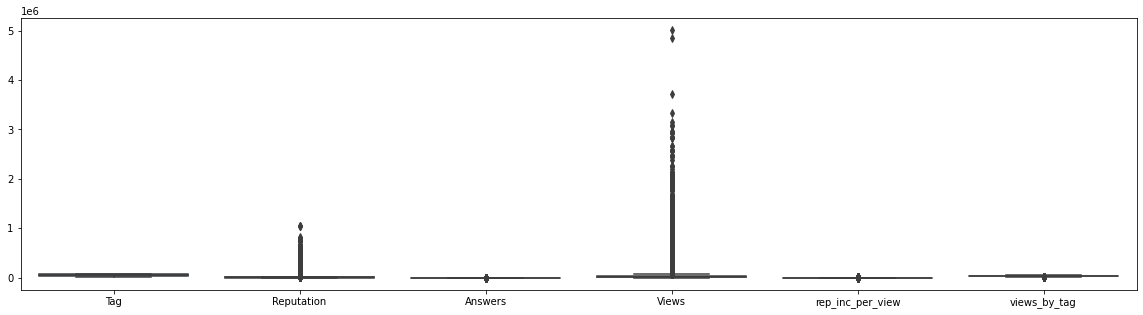

In [ ]:
#finding the presence of outliers in the train set
#the below code is used to find the outliers 
#it can be seen that the Reputation column and the Views column have a lot 
#number number of outliers and because of this the distribution is skewed

plt.figure(figsize=(20,5))
ax = sns.boxplot(data=X_train,orient='v')

In [ ]:
#the below function is used to find out the upper and lower
#boundaries of for a particular feature to point out the outliers
#of that column

def find_boundaries(df,var,dist):                         #taking the dataframe,column,1.5 or 3 may be used
  iqr = df[var].quantile(0.75) - df[var].quantile(0.25)   #calculating the IQR
  lower_boundary = df[var].quantile(0.25) - (iqr*dist)    #calculating the lower bound
  upper_boundary = df[var].quantile(0.75) + (iqr*dist)    #calculating the upper bound
  return upper_boundary,lower_boundary 

In [ ]:
#the below function is used to print the boundaries
#for the features selected for a particular dataframe

boundaries = {}                                                                             #making an empty dictionary
def printing_boundaries(df):                                                                #taking dataframe as a parameter  
  columns = ['Reputation','Answers','Views','rep_inc_per_view','views_by_tag']              #empty dictionary where the upper_boundary,lower_boundary will be stored for each feature
  for col in columns:                                                                       #iterating through the column names is the columns_used list
    boundaries[col] = find_boundaries(df,col,1.5)                                           #storing the values that are returned from the find_boundaries function 
  return boundaries

In [ ]:
#so the output below shows the upper and lower boundaries of data after which
#if there is any data present then that data is an outlier

printing_boundaries(X_train)

{'Answers': (9.5, -2.5),
 'Reputation': (12380.5, -6975.5),
 'Views': (63283.0, -33789.0),
 'rep_inc_per_view': (1.8220115940983286, -1.056803922872865),
 'views_by_tag': (46171.15078489032, 13618.114815258208)}

In [ ]:
#calling the function and passing X_train as the parameter 
#as the number of outliers for each column is very high and if we remove it then
#the data for training the model will reduce a lot and these outliers can provide 
#valuable info as the number is large, thus they are not removed

count_of_outliers(X_train)

dict_values([Tag                 30059
Reputation          30059
Answers             30059
Views               30059
rep_inc_per_view    30059
views_by_tag        30059
dtype: int64, Tag                 14005
Reputation          14005
Answers             14005
Views               14005
rep_inc_per_view    14005
views_by_tag        14005
dtype: int64, Tag                 25251
Reputation          25251
Answers             25251
Views               25251
rep_inc_per_view    25251
views_by_tag        25251
dtype: int64, Tag                 35385
Reputation          35385
Answers             35385
Views               35385
rep_inc_per_view    35385
views_by_tag        35385
dtype: int64, Tag                 0
Reputation          0
Answers             0
Views               0
rep_inc_per_view    0
views_by_tag        0
dtype: int64])

Text(0.5, 1.08, 'Analysis of X_test_final')

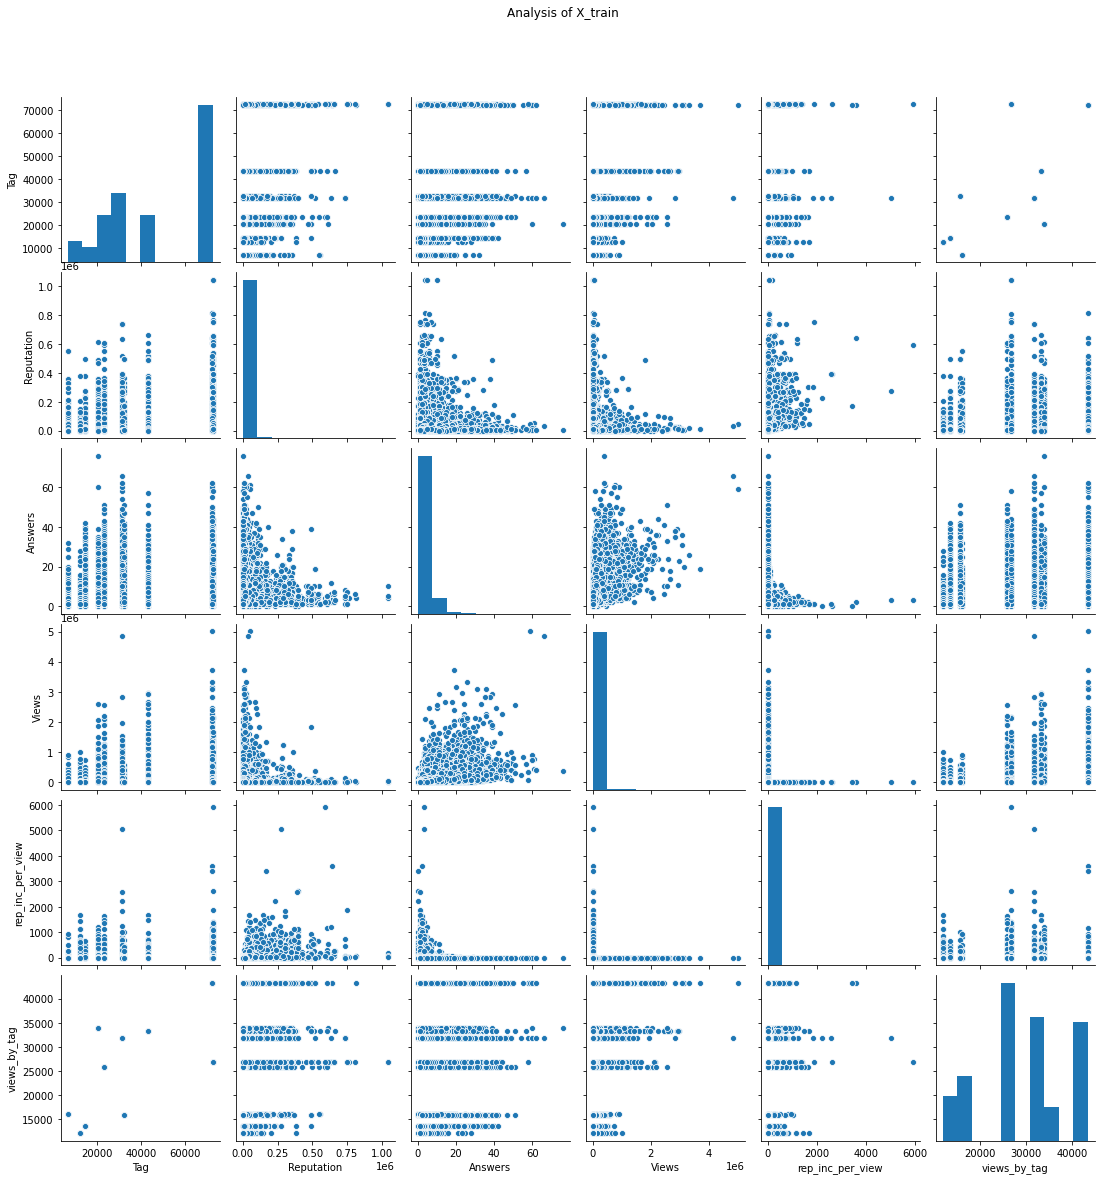

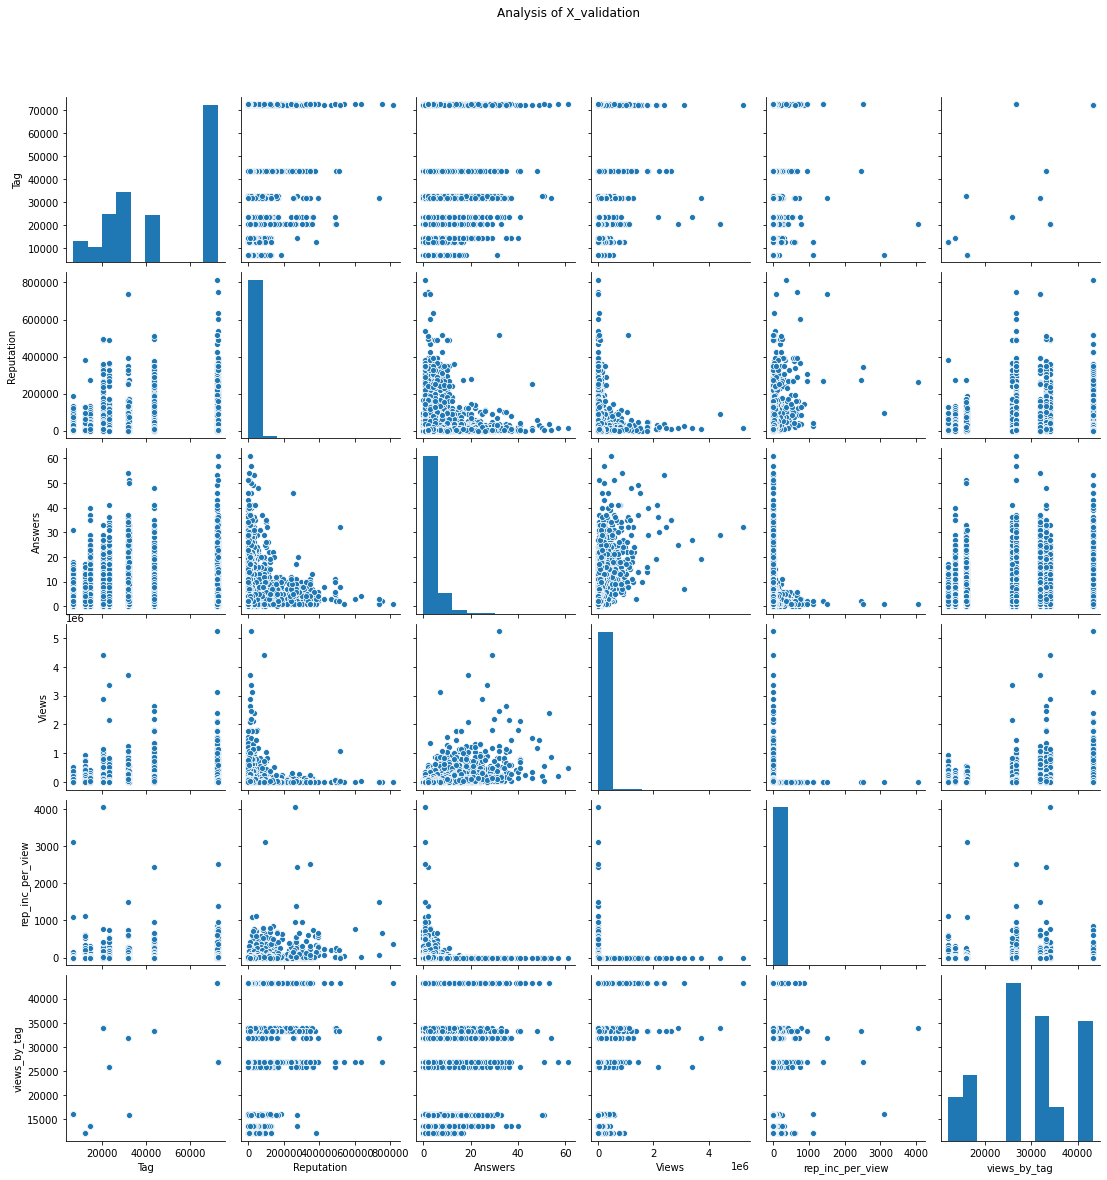

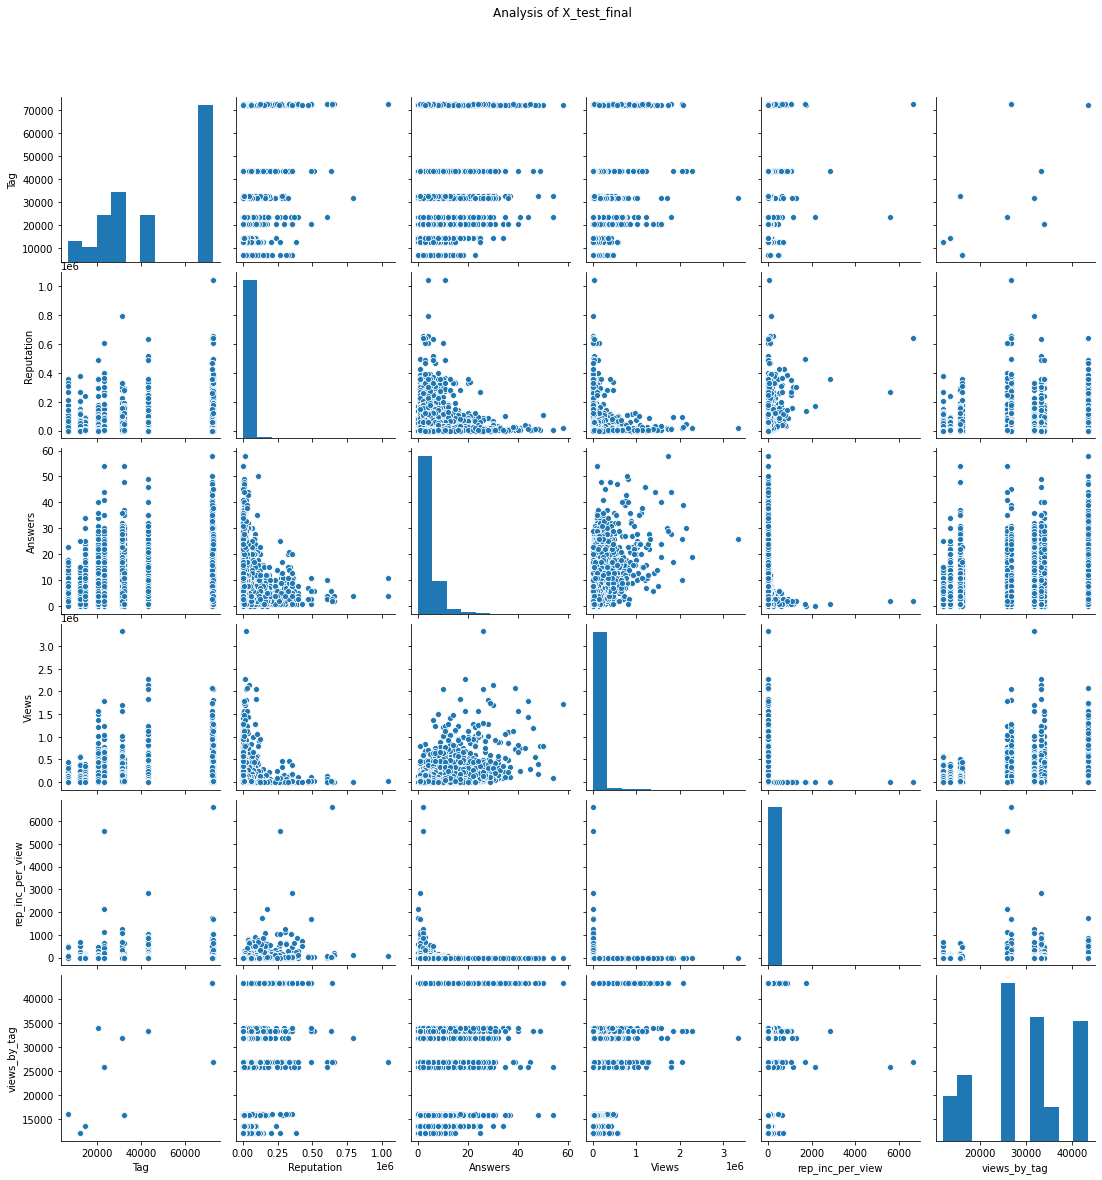

In [ ]:
#Multivariate analysis, here the columns are compared with each to see the 
#relation they have for all the sets of data
#creating the pairplot to show the realations between each of the columns

g=sns.pairplot(data=X_train,)                        #pairplot for train set
g.fig.suptitle('Analysis of X_train',y=1.08)         #subtitle
g=sns.pairplot(data=X_validation)                    #pairplot for validation set
g.fig.suptitle('Analysis of X_validation',y=1.08)    #subtitle 
g=sns.pairplot(data=X_test_final)                    #pairplot for test set
g.fig.suptitle('Analysis of X_test_final',y=1.08)    #subtitle 

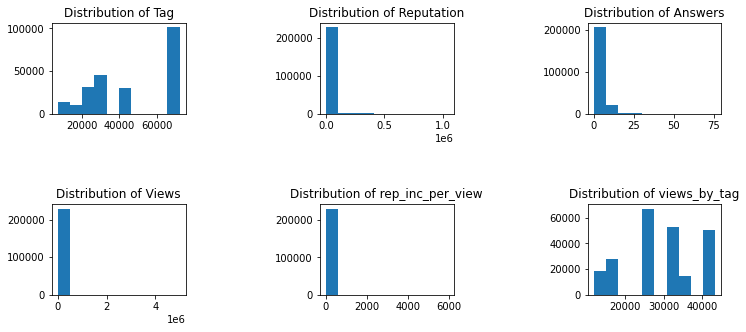

In [ ]:
#let's see the distribution of the train, validation, test data
#Distribution of all the columns in the train set

finding_distribution(X_train)

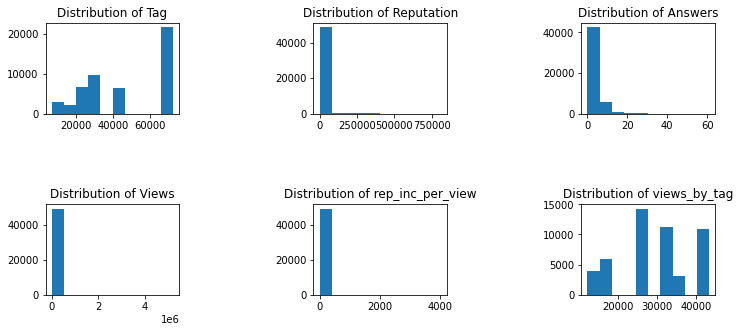

In [ ]:
#distribution of all the columns in validation set

finding_distribution(X_validation)

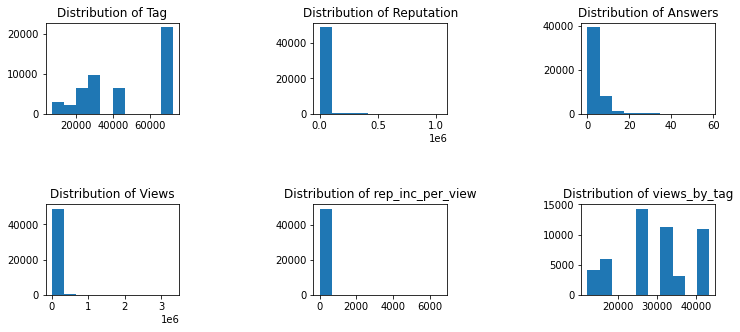

In [ ]:
#distribution of all the columns in the test dataset

finding_distribution(X_test_final)

## Feature Engineering and Feature Selection

In [ ]:
#as the distributions are skewed so transformation on the datasets should be 
#done to keep the distribution close to normal

X_train_transformed = X_train**(1/3)              #cube root transformation of train set
X_validation_transformed = X_validation**(1/3)    #cube root transformation of validation set
X_test_final_transformed = X_test_final**(1/3)    #cube root transformation of test set

In [ ]:
X_train_transformed.describe()

,Tag,Reputation,Answers,Views,rep_inc_per_view,views_by_tag
count,230969.000000,230969.000000,230969.000000,230969.000000,230969.000000,230969.000000
mean,35.137721,13.138734,1.471369,23.429144,0.739772,30.538785
std,6.603725,9.778265,0.399010,13.614188,0.786126,3.617826
min,19.107425,0.000000,0.000000,2.466212,0.000000,22.915893
25%,31.642505,6.565414,1.259921,13.773568,0.283360,29.558537
50%,35.142008,10.723117,1.442250,20.773067,0.505912,31.685796
75%,41.642083,17.237721,1.709976,29.955861,0.905504,32.384605
max,41.686632,101.394724,4.235824,171.054404,18.088178,35.116413


In [ ]:
#as the range between the minimum and the maximum values for the columns Reputation
#and the column Views so scaling of data by which all the data comes under one 
#single range and not having different ranges one small and the other large

scaler = StandardScaler()                                              #making the object of the standard scaler class
X_train_scaled = scaler.fit_transform(X_train_transformed)             #fitting the train data with the object
X_validation_scaled = scaler.fit_transform(X_validation_transformed)   #fitting the validation data 
X_test_final_scaled = scaler.fit_transform(X_test_final_transformed)   #fitting the test data

In [ ]:
#making a list of all the dataframes for which we will find out the distribution

scaled_list = [X_train_scaled,X_validation_scaled,X_test_final_scaled] 

#list of all the names of the dataframes

scaled_list_names = ['X_train_scaled','X_validation_scaled','X_test_final_scaled'] 

In [ ]:
#function to plot the scaled distribution of train,validation,test

def scaled_distribution():
  fig = plt.figure(figsize=(15,10))                             #tuple unpacking and giving the size of the plot 
  fig.subplots_adjust(hspace=1, wspace=1)                       #adjusting space between the subplots
  for i in range(1,4):                                          #looping through each column
    ax = fig.add_subplot(2, 2, i)                               #adding plots while looping
    ax.hist(scaled_list[i-1])                                   #making the distribution for each column
    ax.set_title(f'Distribution of {scaled_list_names[i-1]}')   #giving the title to each distribution

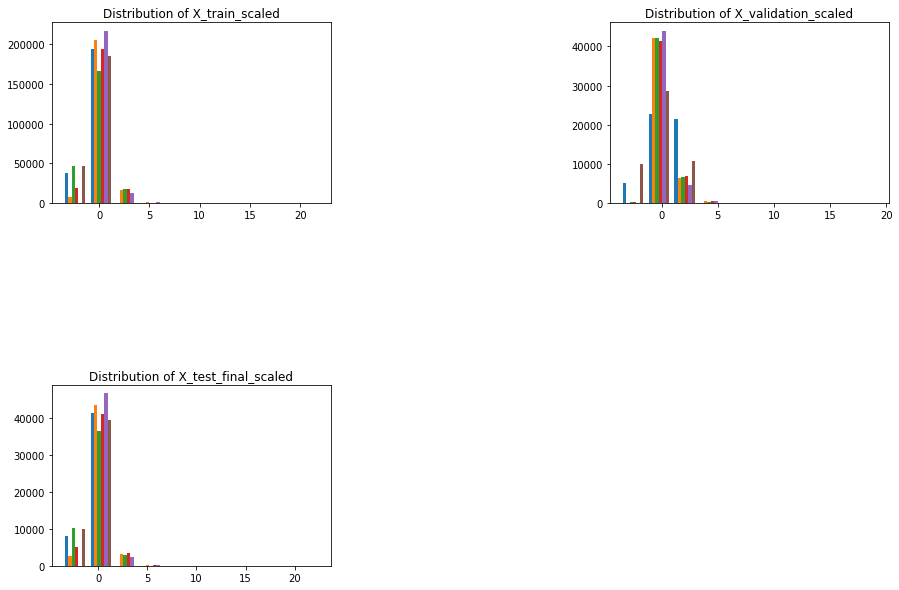

In [ ]:
#from the below plots we can see that the distribution has converted into normal distribution
#for all train,validation and test

scaled_distribution()

In [ ]:
#converting the numpy arrays into dataframe and then giving the columns names

df_list = [X_train,X_validation,X_test_final]
for i in range(3):                                                #looping through all the dataframes,train,validation,test
    df_list[i] = pd.DataFrame(scaled_list[i],columns = ['Tag','Reputation','Answers','Views','rep_inc_per_view','views_by_tag'])

In [ ]:
#copying the values in the dataframes in the list to the original dataframe

X_train = df_list[0]                #copying the value of first element into X_train
X_validation = df_list[1]           #copying the value of second element into X_validation
X_test_final = df_list[2]           #copying the value of third element into X_test_final
X_train.head()

,Tag,Reputation,Answers,Views,rep_inc_per_view,views_by_tag
0,-0.493403,-0.822959,-1.181349,-0.284618,-0.609810,-1.504223
1,0.984956,0.016948,-1.181349,-1.216963,1.525598,1.265301
2,0.984956,-0.696856,-1.181349,-0.757437,-0.327691,1.265301
3,-1.172787,-0.617508,-0.072980,0.072266,-0.571053,0.510203
4,0.991702,0.289814,2.627689,1.260085,-0.440393,-0.174390


In [ ]:
#seeing the relation between each columns to select features which are important in model building

X_train.corr()

,Tag,Reputation,Answers,Views,rep_inc_per_view,views_by_tag
Tag,1.000000,0.075997,0.121761,0.136012,-0.017992,0.625031
Reputation,0.075997,1.000000,0.163747,0.134059,0.665054,0.028855
Answers,0.121761,0.163747,1.000000,0.590481,-0.184930,0.124677
Views,0.136012,0.134059,0.590481,1.000000,-0.391825,0.195790
rep_inc_per_view,-0.017992,0.665054,-0.184930,-0.391825,1.000000,-0.078266
views_by_tag,0.625031,0.028855,0.124677,0.195790,-0.078266,1.000000


In [ ]:
# finding the constant features

sel = VarianceThreshold(threshold=0)        #for constant features we set the threshold as 0
sel.fit(X_train)  

VarianceThreshold(threshold=0)

In [ ]:
#this code shows the number of features that are not constant

sum(sel.get_support())

6

In [ ]:
# finally we can print the constant features
#from the below output we can see that there are no constant features

[x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

[]

In [ ]:
#finding the quasi-constant features

sel_quasi = VarianceThreshold(threshold=0.01)      #for quasi-constant values we set the values as 0.01
sel_quasi.fit(X_train)  

VarianceThreshold(threshold=0.01)

In [ ]:
#this shows the number of columns that are not quasi-constant

sum(sel_quasi.get_support())

6

In [ ]:
#from the output of the below code we can see that there are no quasi constant features

[x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

[]

In [ ]:
X_train.head()          #printing the first 5 rows of the dataframe

,Tag,Reputation,Answers,Views,rep_inc_per_view,views_by_tag
0,-0.493403,-0.822959,-1.181349,-0.284618,-0.609810,-1.504223
1,0.984956,0.016948,-1.181349,-1.216963,1.525598,1.265301
2,0.984956,-0.696856,-1.181349,-0.757437,-0.327691,1.265301
3,-1.172787,-0.617508,-0.072980,0.072266,-0.571053,0.510203
4,0.991702,0.289814,2.627689,1.260085,-0.440393,-0.174390


- No wrapper methods or embedded methods are used to filter the features because - 
    * the number of features are very less
    * for this small amount of features it will computationally expensive
    * according to me all the features are important in model building

# Model building starts from here

In [ ]:
#importing all the necessary models and libraries to evaluate and make the model the optimum one

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,GridSearchCV

In [ ]:
#making a dictionary of all the models that are to be used 

model_dict = {
    'lr':LinearRegression(),
    'lcv':LassoCV(),
    'rcv':RidgeCV(),
    'knr':KNeighborsRegressor(),
    'dtr':DecisionTreeRegressor(),
    'rfr':RandomForestRegressor(),
    'gbr':GradientBoostingRegressor()
}

#model_score is a dictionary containing the scores of models
#model_rmse is a dictionary containing the rmse values

model_score = {}    
model_rmse = {}
cross_valid_score = {}           #dictionary to store the cross_validation_scores for each model

In [ ]:
#the below function is used to go through each of the models in the dictionary,
#it takes the train and test data as parameters and then finds out the score and the rmse of each.

def model_selection(train_df,train_ser,test_df,test_ser):
    for key,value in model_dict.items():                                  #a loop that runs through each key and value of the model dictionary
        model = value                                                     #the model is chosen 
        model.fit(train_df,train_ser)                                     #the model is then fitted with the train data
        test_pred = model.predict(test_df)                                #prediction of the test dataset occurs
        model_score[key] = model.score(test_df,test_ser)                  #the model score is calculated here
        model_rmse[key] = np.sqrt(mean_squared_error(test_ser,test_pred)) #the rmse due to a particular model is calculated
    return model_score,model_rmse

In [ ]:
#in the code below the cross validation for each of the model is done, which helps in good model selection 

def cross_validation_checker(train_df,train_ser,test_df,test_ser):               #taking the train and test dataframes as parameters
    concatinated_df = pd.concat([train_df,test_df])                              #concatinating the train and test dataframes
    concatinated_ser = train_ser.append(test_ser)                                #concatinating the train and test series
    for key,value in model_dict.items():                                         #iterating through the dictionary
        model = value                                                            #making object of the particular model class
        score = cross_val_score(model,concatinated_df,concatinated_ser,cv=5,scoring='neg_root_mean_squared_error').mean()   #calculating the cv score
        print(f'Cross validation score of {key}:\nRMSE mean:{score}')            #printing it out 

In [ ]:
#from the below output we can see that the rmse mean for gbr that is GradientBoosting is the minimum

cross_validation_checker(X_train,Y_train,X_validation,Y_validation)

Cross validation score of lr:
RMSE mean:-3520.265077325935
Cross validation score of lcv:
RMSE mean:-3520.2572404138236
Cross validation score of rcv:
RMSE mean:-3520.2648488550353
Cross validation score of knr:
RMSE mean:-1690.3209189561865
Cross validation score of dtr:
RMSE mean:-1855.1838457582794
Cross validation score of rfr:
RMSE mean:-1431.692057745728
Cross validation score of gbr:
RMSE mean:-1350.0902533936314


In [ ]:
#now let's check the initial model performance

model = GradientBoostingRegressor()                                      #declaring the object for the model class
model.fit(X_train,Y_train)                                               #fiting the model with the training dataset
Y_pred = model.predict(X_test_final)                                     #predicting the values from the test data
print(f'The model score is {model.score(X_test_final,Y_test_final)}')    #prints the model score
print(f'The rmse is {np.sqrt(mean_squared_error(Y_test_final,Y_pred))}') #prints the rmse

The model score is 0.8976486127211192
The rmse is 869.7590071420485


In [ ]:
#now due to the above result, the model should be tuned to give better results 
#in the below a dictionary of all the parameters are given 

parameters = {'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],          
              'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],        
              'max_depth': np.linspace(1, 6, 6, endpoint=True),
              'min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True),
              'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
              'max_features':list(range(1,X_train.shape[1])),
              }

In [ ]:
#this is an empty dictionary to contain the initial values of the different parameters 

parameter_dict = {'learning_rate':[0,0],
                  'n_estimators':[0,0],
                  'max_depth' : [0,0],
                  'min_samples_split' : [0,0],
                  'min_samples_leaf' : [0,0],
                  'max_features' : [0,0],
                  }

In [ ]:
#this is a function which is used to store the values of the rmse and the r2_score 
#for each parameter that is tuned, it is stored by using the below condition

def storing_data(key,r2_score,rmse):                    #taking the key,r2_score,rmse as the parameters
  if value[0]==0 or value[0]<r2_score:                  #checking if the value present is 0 or is less than the current value(for r2_score)
    value[0] = r2_score                                 #if yes then the value is stored
  if value[1]==0 or value[1]>rmse:                      #checking if the value present is 0 or is less than the current value(for rmse)
    value[1] = rmse                                     #if yes then the value is stored

In [ ]:
#this is for checking the best learning rate from a list of learning rates 
#from the below output of learning rates it can be seen that 
#learning_rate = 0.1 has the best results

for p in parameters['learning_rate']:                                  #getting the values for the hyperparameter learning_rate
  print(f'result using learning: {p}')                                 
  model = GradientBoostingRegressor(learning_rate=p)                   #taking that value as to tune the hyperparameter
  model.fit(X_train,Y_train)                                           #fitting the model with the train data
  r2_score = model.score(X_test_final,Y_test_final)                    #calculating the r2_score
  print(f'r2_score: {r2_score}')                                       #printing the value of r2_score
  Y_pred = model.predict(X_test_final)                                 #predicting the result using the test data
  rmse = np.sqrt(mean_squared_error(Y_test_final,Y_pred))              #calculating the rmse 
  print(f'rmse: {rmse}')                                               #printing the rmse
  for key,value in parameter_dict.items():                             #iterating through the dictionary
    if key=='learning_rate':                                           #checking if the key is learning rate or not
      storing_data(key,r2_score,rmse)                                  #if yes then passing the parameters to the functions

result using learning: 1
r2_score: 0.7559873492050438
rmse: 1342.945040277343
result using learning: 0.5
r2_score: 0.8627097676609163
rmse: 1007.3302784009711
result using learning: 0.25
r2_score: 0.8810087691176892
rmse: 937.7985279945945
result using learning: 0.1
r2_score: 0.8976415942190883
rmse: 869.7888274545768
result using learning: 0.05
r2_score: 0.8951724373772355
rmse: 880.2171219853947
result using learning: 0.01
r2_score: 0.6706953640613843
rmse: 1560.0948045961015


In [ ]:
print(parameter_dict)                 #printing the dictionary

{'learning_rate': [0.8976415942190883, 869.7888274545768], 'n_estimators': [0, 0], 'max_depth': [0, 0], 'min_samples_split': [0, 0], 'min_samples_leaf': [0, 0], 'max_features': [0, 0]}


In [ ]:
#this is for checking the optimal n_estimators from a list of n_estimators
#we can see from the output below n_estimators =  64 gives the best result
#the explanation for the below code is the same as the above one except the hyperparameter is different.

for p in parameters['n_estimators']:
  print(f'result using n_estimators: {p}')
  model = GradientBoostingRegressor(n_estimators=p)
  model.fit(X_train,Y_train)
  r2_score = model.score(X_test_final,Y_test_final)
  print(f'r2_score: {r2_score}')
  Y_pred = model.predict(X_test_final)
  rmse = np.sqrt(mean_squared_error(Y_test_final,Y_pred))
  print(f'rmse: {rmse}\n')
  for key,value in parameter_dict.items():
    if key=='n_estimators':
      storing_data(key,r2_score,rmse)   

result using n_estimators: 1
r2_score: 0.13859159717022684
rmse: 2523.2287251685434

result using n_estimators: 2
r2_score: 0.2499094962361691
rmse: 2354.5553376058224

result using n_estimators: 4
r2_score: 0.3970511156537454
rmse: 2111.019845845977

result using n_estimators: 8
r2_score: 0.625879056445384
rmse: 1662.8691594298132

result using n_estimators: 16
r2_score: 0.7744235950437732
rmse: 1291.2160141208312

result using n_estimators: 32
r2_score: 0.8615056874727973
rmse: 1011.7379431431721

result using n_estimators: 64
r2_score: 0.8977552831342137
rmse: 869.3056584342199

result using n_estimators: 100
r2_score: 0.8975750388839162
rmse: 870.0715579221778

result using n_estimators: 200
r2_score: 0.8889885696912517
rmse: 905.8075105733627



In [ ]:
#this is for checking the optimal max_depth from a list of max_depth 
#from the below output we can see that max_depth = 3 gives the best result
#the explanation for this code is the same as the explanation for the 
#code with learning_rate as the hyperparameter

for p in parameters['max_depth']:
  print(f'result using max_depth: {p}')
  model = GradientBoostingRegressor(max_depth=p)
  model.fit(X_train,Y_train)
  r2_score = model.score(X_test_final,Y_test_final)
  print(f'r2_score: {r2_score}')
  Y_pred = model.predict(X_test_final)
  rmse = np.sqrt(mean_squared_error(Y_test_final,Y_pred))
  print(f'rmse: {rmse}\n')
  for key,value in parameter_dict.items():
    if key=='max_depth':
      storing_data(key,r2_score,rmse)       

result using max_depth: 1.0
r2_score: 0.35037030466854524
rmse: 2191.2150523518344

result using max_depth: 2.0
r2_score: 0.8969185898137942
rmse: 872.8552809133178

result using max_depth: 3.0
r2_score: 0.8976507107122447
rmse: 869.7500929686411

result using max_depth: 4.0
r2_score: 0.8975281476749544
rmse: 870.2706990218697

result using max_depth: 5.0
r2_score: 0.8917489343364491
rmse: 894.4749002826665

result using max_depth: 6.0
r2_score: 0.8790036905054173
rmse: 945.6667737674701



In [ ]:
print(parameter_dict)

{'learning_rate': [0.8976415942190883, 869.7888274545768], 'n_estimators': [0.8977552831342137, 869.3056584342199], 'max_depth': [0.8976507107122447, 869.7500929686411], 'min_samples_split': [0, 0], 'min_samples_leaf': [0, 0], 'max_features': [0, 0]}


In [ ]:
#this is for checking the optimal min_samples_split from a list of min_samples_split 
#from the below output we can see that min_samples_split =  0.1 gives the best result
#the explanation for this code is the same as the explanation for the 
#code with learning_rate as the hyperparameter

for p in parameters['min_samples_split']:
  print(f'result using min_samples_split: {p}')
  model = GradientBoostingRegressor(min_samples_split=p)
  model.fit(X_train,Y_train)
  print(f'r2_score: {model.score(X_test_final,Y_test_final)}')
  Y_pred = model.predict(X_test_final)
  print(f'rmse: {np.sqrt(mean_squared_error(Y_test_final,Y_pred))}\n')
  for key,value in parameter_dict.items():
    if key=='min_samples_split':
      storing_data(key,r2_score,rmse) 

result using min_samples_split: 0.1
r2_score: 0.5946734221504135
rmse: 1730.8307775594615

result using min_samples_split: 0.2
r2_score: 0.5590617939076143
rmse: 1805.2648811251645

result using min_samples_split: 0.30000000000000004
r2_score: 0.5750244234899395
rmse: 1772.2870089282133

result using min_samples_split: 0.4
r2_score: 0.5839806873953302
rmse: 1753.5122905497906

result using min_samples_split: 0.5
r2_score: 0.5839806873953308
rmse: 1753.5122905497892

result using min_samples_split: 0.6
r2_score: 0.5839806873953296
rmse: 1753.512290549792

result using min_samples_split: 0.7000000000000001
r2_score: 0.5724129229038792
rmse: 1777.7240743049792

result using min_samples_split: 0.8
r2_score: 0.5622736770507605
rmse: 1798.6779065891967

result using min_samples_split: 0.9
r2_score: 0.4811849073832898
rmse: 1958.2059639806512

result using min_samples_split: 1.0
r2_score: 0.35037030466854335
rmse: 2191.2150523518376



In [ ]:
print(parameter_dict)

{'learning_rate': [0.8976415942190883, 869.7888274545768], 'n_estimators': [0.8977552831342137, 869.3056584342199], 'max_depth': [0.8976507107122447, 869.7500929686411], 'min_samples_split': [0.8790036905054173, 945.6667737674701], 'min_samples_leaf': [0, 0], 'max_features': [0, 0]}


In [ ]:
#this is for checking the optimal min_samples_leaf from a list of min_samples_leaf 
#from the below output we can see that min_samples_leaf = 0.1 gives the best result
#the explanation for this code is the same as the explanation for the 
#code with learning_rate as the hyperparameter

for p in parameters['min_samples_leaf']:
  print(f'result using min_samples_leaf: {p}')
  model = GradientBoostingRegressor(min_samples_leaf=p)
  model.fit(X_train,Y_train)
  r2_score = model.score(X_test_final,Y_test_final)
  print(f'r2_score: {r2_score}')
  Y_pred = model.predict(X_test_final)
  rmse = np.sqrt(mean_squared_error(Y_test_final,Y_pred))
  print(f'rmse: {rmse}\n')
  for key,value in parameter_dict.items():
    if key=='min_samples_leaf':
      storing_data(key,r2_score,rmse) 

result using min_samples_leaf: 0.1
r2_score: 0.1922328729345449
rmse: 2443.4032981851074

result using min_samples_leaf: 0.2
r2_score: 0.10043809797193161
rmse: 2578.5027280640575

result using min_samples_leaf: 0.30000000000000004
r2_score: 0.055196551184576004
rmse: 2642.547503861484

result using min_samples_leaf: 0.4
r2_score: 0.03196707140507993
rmse: 2674.8358387954227

result using min_samples_leaf: 0.5
r2_score: -2.3436944795340867e-05
rmse: 2718.674147500209



In [ ]:
print(parameter_dict)

{'learning_rate': [0.8976415942190883, 869.7888274545768], 'n_estimators': [0.8977552831342137, 869.3056584342199], 'max_depth': [0.8976507107122447, 869.7500929686411], 'min_samples_split': [0.8790036905054173, 945.6667737674701], 'min_samples_leaf': [0.1922328729345449, 2443.4032981851074], 'max_features': [0, 0]}


In [ ]:
#this is for checking the optimal max_features from a list of max_features 
#from the output below we can see that max_features = 3 gives the best result
#the explanation for this code is the same as the explanation for the 
#code with learning_rate as the hyperparameter

for p in parameters['max_features']:
  print(f'result using max_features: {p}')
  model = GradientBoostingRegressor(max_features=p)
  model.fit(X_train,Y_train)
  r2_score = model.score(X_test_final,Y_test_final)
  print(f'r2_score: {r2_score}')
  Y_pred = model.predict(X_test_final)
  rmse = np.sqrt(mean_squared_error(Y_test_final,Y_pred))
  print(f'rmse: {rmse}\n')
  for key,value in parameter_dict.items():
    if key=='max_features':
      storing_data(key,r2_score,rmse) 

result using max_features: 1
r2_score: 0.8328010715579676
rmse: 1111.651896122345

result using max_features: 2
r2_score: 0.8886599439639452
rmse: 907.1472450412587

result using max_features: 3
r2_score: 0.882261481856606
rmse: 932.8490013611796

result using max_features: 4
r2_score: 0.8969942567212761
rmse: 872.5348623992953

result using max_features: 5
r2_score: 0.9009834341861825
rmse: 855.472391162489



In [ ]:
print(parameter_dict)          #printing the dictionary

{'learning_rate': [0.8976415942190883, 869.7888274545768], 'n_estimators': [0.8977552831342137, 869.3056584342199], 'max_depth': [0.8976507107122447, 869.7500929686411], 'min_samples_split': [0.8790036905054173, 945.6667737674701], 'min_samples_leaf': [0.1922328729345449, 2443.4032981851074], 'max_features': [0.9009834341861825, 855.472391162489]}


In [ ]:
#now let us compare and get the best result of all the results 

max_score = 0                                        #taking the initial r2_score as 0
min_rmse = 3000                                      #taking the initial minimum rmse as 3000
for key,value in parameter_dict.items():             #iterating through the dictionary
  if max_score < value[0]:                           #condition for getting the highest score
    max_score = value[0]                             #copying the value if the condition is met
  if min_rmse > value[1]:                            #condtition for getting the lowest rmse
    min_rmse = value[1]                              #copying the value if the condition is met
print(f'The best r2_score : {max_score}\nThe lowest rmse: {min_rmse}\nThus {key} is to be tuned to get the best model')    #printing them

The best r2_score : 0.9009834341861825
The lowest rmse: 855.472391162489
Thus max_features is to be tuned to get the best model


In [ ]:
#the final model with the tuning done

model = GradientBoostingRegressor(max_features = 5)        #fitting the model with max_features as 5 as this gave the best result
model.fit(X_train,Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#this line of code gives the predicted values 

Y_pred = model.predict(X_test_final)

In [ ]:
#this gives the final r2_score

model.score(X_test_final,Y_test_final)

0.9000233552123743

In [ ]:
#this gives the final rmse

np.sqrt(mean_squared_error(Y_test_final,Y_pred))

859.6097783293852

# The End

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# root_path = '/content/gdrive/My Drive/Colab Notebooks/test_8i3B3FC.csv'

In [ ]:
# df_test_final = pd.read_csv(root_path)
# df_test_final.head()

In [ ]:
# df_test_final = pd.DataFrame(,columns=['Upvotes'])
# df_test_final.head()

In [ ]:
# df_test_final['ID'] = df_test_ID

In [ ]:
# columnsTitles=["ID","Upvotes"]

# df_test_final=df_test_final.reindex(columns=columnsTitles)

In [ ]:
# df_test_final.head()

In [ ]:
# df_test_final.to_csv(r'C:\Users\hrkadmin\Documents\Python Scripts\upvotes_submission.csv',index=False)